In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
# importovanie potrebných knižníc

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,  RocCurveDisplay, roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import ADASYN
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score, classification_report

/var/folders/lc/0tq3t3m97j18yp2pgzc9h2vw0000gn/T/ipykernel_83049/1858439271.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# inštalácia balíkov python
%pip install mlxtend
%pip install - -upgrade pip
%pip install networkx

Note: you may need to restart the kernel to use updated packages.

Usage:   
  /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install [options] <requirement specifier> [package-index-options] ...
  /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install [options] -r <requirements file> [package-index-options] ...
  /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install [options] [-e] <vcs project url> ...
  /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install [options] [-e] <local project path> ...
  /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install [options] <archive url/path> ...

no such option: -u
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# načitanie datasetu
df = pd.read_csv("stroke_data.csv")
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [4]:
# odstránenie stĺpca "id"
df = df.drop(columns=['id'])

In [5]:
# premenovanie atribútov z angličtiny do slovenčiny
df = df.rename(columns={'age': 'vek'})
df = df.rename(columns={'heart_disease': 'srdcova_choroba'})
df = df.rename(columns={'work_type': 'typ_prace'})
df = df.rename(columns={'smoking_status': 'fajcenie'})
df = df.rename(columns={'stroke': 'mrtvica'})
df = df.rename(columns={'Residence_type': 'typ_rezidencie'})
df = df.rename(columns={'avg_glucose_level': 'priemerna_hladina_glukozy'})
df = df.rename(columns={'gender': 'pohlavie'})
df = df.rename(columns={'ever_married': 'manželstvo'})
df = df.rename(columns={'hypertension': 'krvny_tlak'})

In [6]:
# zobrazenie prvých 5 riadkov datasetu
df.head(5)

,pohlavie,vek,krvny_tlak,srdcova_choroba,manželstvo,typ_prace,typ_rezidencie,priemerna_hladina_glukozy,bmi,fajcenie,mrtvica
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [7]:
# spočítanie jednotlivých hodnôt atribútu mrtvica
df.mrtvica.value_counts()

mrtvica
0    4861
1     249
Name: count, dtype: int64

In [8]:
# nahradenie chýbajúcich hodnôt v stĺpci "bmi" priemerom všetkých hodnôt v tomto stĺpci
df['bmi'].fillna(df['bmi'].mean(), inplace=True)

/var/folders/lc/0tq3t3m97j18yp2pgzc9h2vw0000gn/T/ipykernel_83049/3647075269.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(df['bmi'].mean(), inplace=True)


In [9]:
# prevedenie textových hodnôt na číselné
df["pohlavie"] = df["pohlavie"].replace({"Male":0, "Female":1})
df["manželstvo"] = df["manželstvo"].replace({"No":0, "Yes":1})
df["fajcenie"] = df["fajcenie"].replace({"Unknown":0, "smokes":1, "formerly smoked":2, "never smoked":3 })
df["typ_prace"] = df["typ_prace"].replace({"Private":0, "Self-employed":1, "Govt_job":2})
df["typ_rezidencie"] = df["typ_rezidencie"].replace({"Urban":0, "Rural":1})

/var/folders/lc/0tq3t3m97j18yp2pgzc9h2vw0000gn/T/ipykernel_83049/1893360737.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["manželstvo"] = df["manželstvo"].replace({"No":0, "Yes":1})
/var/folders/lc/0tq3t3m97j18yp2pgzc9h2vw0000gn/T/ipykernel_83049/1893360737.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["fajcenie"] = df["fajcenie"].replace({"Unknown":0, "smokes":1, "formerly smoked":2, "never smoked":3 })
/var/folders/lc/0tq3t3m97j18yp2pgzc9h2vw0000gn/T/ipykernel_83049/1893360737.py:6: FutureWarning: Downcasting b

In [10]:
# zobrazenie informácií o atribútoch v datasete
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   pohlavie                   5110 non-null   object 
 1   vek                        5110 non-null   float64
 2   krvny_tlak                 5110 non-null   int64  
 3   srdcova_choroba            5110 non-null   int64  
 4   manželstvo                 5110 non-null   int64  
 5   typ_prace                  5110 non-null   object 
 6   typ_rezidencie             5110 non-null   int64  
 7   priemerna_hladina_glukozy  5110 non-null   float64
 8   bmi                        5110 non-null   float64
 9   fajcenie                   5110 non-null   int64  
 10  mrtvica                    5110 non-null   int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 439.3+ KB


In [11]:
# prevod kategorických na číselné hodnoty
df['pohlavie'], _ = pd.factorize(df['pohlavie'])
df['typ_prace'], _ = pd.factorize(df['typ_prace'])

In [12]:
# prevedenie hodnôt na celé čísla
df['vek'] = df['vek'].astype('int64')
df['priemerna_hladina_glukozy'] = df['priemerna_hladina_glukozy'].astype('int64')
df['bmi'] = df['bmi'].astype('int64')

In [13]:
# zobrazenie informácií o atribútoch v datasete
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   pohlavie                   5110 non-null   int64
 1   vek                        5110 non-null   int64
 2   krvny_tlak                 5110 non-null   int64
 3   srdcova_choroba            5110 non-null   int64
 4   manželstvo                 5110 non-null   int64
 5   typ_prace                  5110 non-null   int64
 6   typ_rezidencie             5110 non-null   int64
 7   priemerna_hladina_glukozy  5110 non-null   int64
 8   bmi                        5110 non-null   int64
 9   fajcenie                   5110 non-null   int64
 10  mrtvica                    5110 non-null   int64
dtypes: int64(11)
memory usage: 439.3 KB


In [14]:
# počet prazdných hodnôt v jednotlivých atribútoch
df.isna().sum()

pohlavie                     0
vek                          0
krvny_tlak                   0
srdcova_choroba              0
manželstvo                   0
typ_prace                    0
typ_rezidencie               0
priemerna_hladina_glukozy    0
bmi                          0
fajcenie                     0
mrtvica                      0
dtype: int64

In [15]:
# výber atribútov podľa asociačných pravidiel
cols = ["pohlavie", "vek", "krvny_tlak", "srdcova_choroba", "manželstvo", "priemerna_hladina_glukozy", "fajcenie", "typ_prace", "typ_rezidencie"]


In [16]:
# normalizácia 
scaler = MinMaxScaler()
df[cols] = scaler.fit_transform(df[cols])
df[cols].head()

,pohlavie,vek,krvny_tlak,srdcova_choroba,manželstvo,priemerna_hladina_glukozy,fajcenie,typ_prace,typ_rezidencie
0,0.0,0.817073,0.0,1.0,1.0,0.800926,0.666667,0.00,0.0
1,0.5,0.743902,0.0,0.0,1.0,0.680556,1.000000,0.25,1.0
2,0.0,0.975610,0.0,1.0,1.0,0.231481,1.000000,0.00,1.0
3,0.5,0.597561,0.0,0.0,1.0,0.537037,0.333333,0.00,0.0
4,0.5,0.963415,1.0,0.0,1.0,0.550926,1.000000,0.25,1.0


In [17]:
# rozdelenie dát na trénovaciu a testovaciu časť (70:30)
x = df[["pohlavie", "vek", "manželstvo", "typ_prace", "typ_rezidencie", "priemerna_hladina_glukozy", "bmi", "fajcenie"]]
y = df["mrtvica"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)


In [18]:
# trénovanie a evaluácia modelu Naivný Bayes na atribútoch vybraných asociačnými pravidlami
model_NB = GaussianNB().fit(x_train, y_train)
y_pred_NB = model_NB.predict(x_test)

Hodnoty metrík:
F1 Score: 0.2472
Recall: 0.2651
Accuracy: 0.9126
Precision: 0.2316
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1450
           1       0.23      0.27      0.25        83

    accuracy                           0.91      1533
   macro avg       0.59      0.61      0.60      1533
weighted avg       0.92      0.91      0.92      1533

-----------------------------------------------------


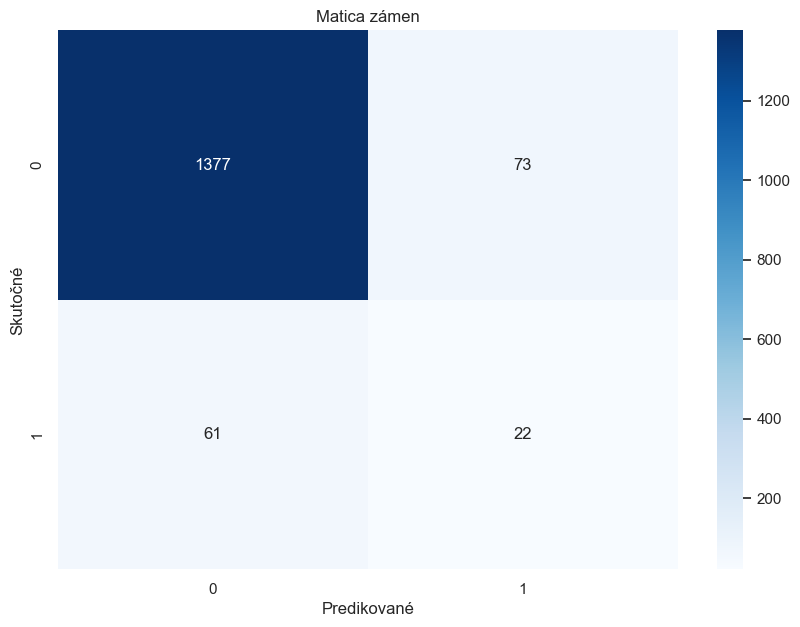

In [19]:
# výpočet metrík f1, recall, accuracy, precision
f1 = f1_score(y_test, y_pred_NB)
recall = recall_score(y_test, y_pred_NB)
accuracy = accuracy_score(y_test, y_pred_NB)
precision = precision_score(y_test, y_pred_NB)

print("Hodnoty metrík:")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print("-----------------------------------------------------")
print(classification_report(y_test, y_pred_NB))
print("-----------------------------------------------------")

# vytvorenie a vizualizácia matice zámen 
cm = confusion_matrix(y_test, y_pred_NB)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predikované')
plt.ylabel('Skutočné')
plt.title('Matica zámen')
plt.show()

 
AUC: 0.60736
-------------------------------------


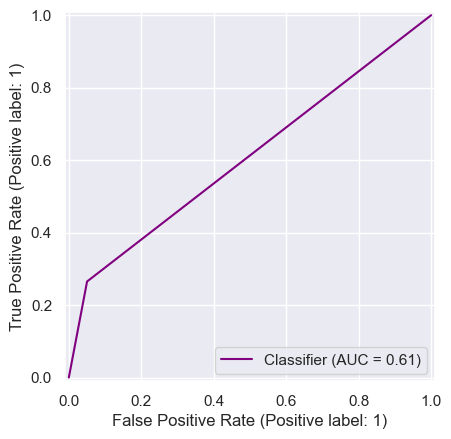

In [20]:
# výpočet a zobrazenie ROC krivky a AUC (plochy pod ROC krivkou)
auc_NB = roc_auc_score(y_test, y_pred_NB)
roc_NB = RocCurveDisplay.from_predictions(y_test, y_pred_NB, color="purple")

print(" ")
print(f"AUC: {auc_NB:.5f}")
print("-------------------------------------")
plt.show()

In [21]:
from imblearn.over_sampling import ADASYN
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay

# aplikovanie metódy ADASYN na vyváženie dát
adasyn = ADASYN(sampling_strategy=1.0, n_neighbors=7, random_state=1)
x_adasyn, y_adasyn = adasyn.fit_resample(x, y)

# rozdelenie dát na trénovaciu a testovaciu časť (70:30)
x_train_adasyn, x_test_adasyn, y_train_adasyn, y_test_adasyn = train_test_split(x_adasyn, y_adasyn, test_size=0.3, stratify=y_adasyn, random_state=20)


In [22]:
# trénovanie a evaluácia modelu Naivný Bayes na vyvážených dátach
model_NB_adasyn = GaussianNB().fit(x_train_adasyn, y_train_adasyn)
y_pred_adasyn = model_NB_adasyn.predict(x_test_adasyn)

Hodnoty metrík (ADASYN dáta):
F1 Score: 0.7894
Recall: 0.8759
Accuracy: 0.7684
Precision: 0.7185
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.66      0.74      1459
           1       0.72      0.88      0.79      1434

    accuracy                           0.77      2893
   macro avg       0.78      0.77      0.77      2893
weighted avg       0.78      0.77      0.77      2893

-----------------------------------------------------


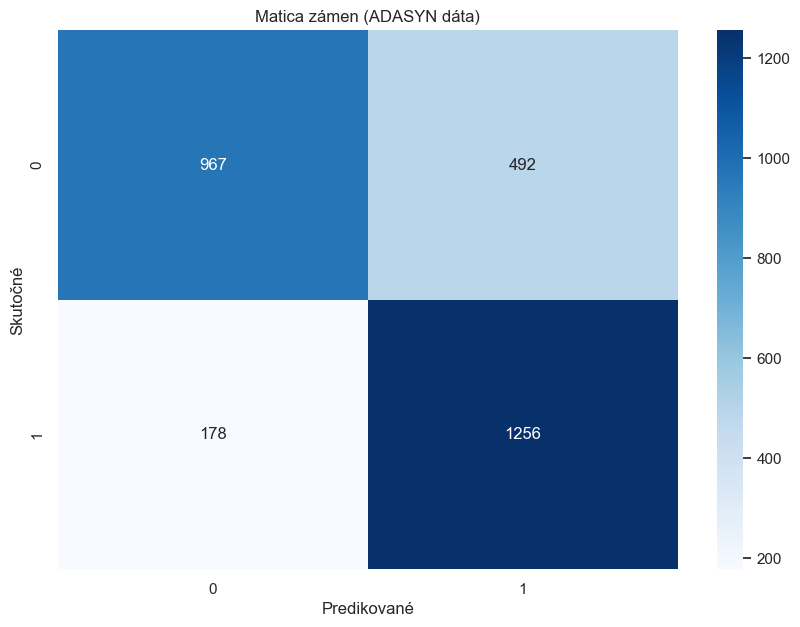

In [23]:
# výpočet metrík f1, recall, accuracy, precision
f1_adasyn = f1_score(y_test_adasyn, y_pred_adasyn)
recall_adasyn = recall_score(y_test_adasyn, y_pred_adasyn)
accuracy_adasyn = accuracy_score(y_test_adasyn, y_pred_adasyn)
precision_adasyn = precision_score(y_test_adasyn, y_pred_adasyn)

print("Hodnoty metrík (ADASYN dáta):")
print(f"F1 Score: {f1_adasyn:.4f}")
print(f"Recall: {recall_adasyn:.4f}")
print(f"Accuracy: {accuracy_adasyn:.4f}")
print(f"Precision: {precision_adasyn:.4f}")
print("-----------------------------------------------------")
print(classification_report(y_test_adasyn, y_pred_adasyn))
print("-----------------------------------------------------")

# vytvorenie a vizualizácia matice zámen 
cm_adasyn = confusion_matrix(y_test_adasyn, y_pred_adasyn)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_adasyn, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predikované')
plt.ylabel('Skutočné')
plt.title('Matica zámen (ADASYN dáta)')
plt.show()

 
AUC: 0.76933
-------------------------------------


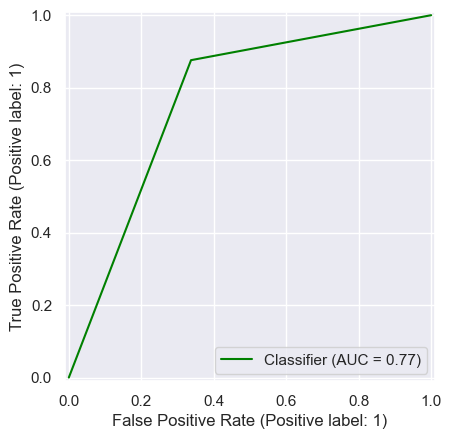

In [24]:
# výpočet a zobrazenie ROC krivky a AUC (plochy pod ROC krivkou)
auc_adasyn = roc_auc_score(y_test_adasyn, y_pred_adasyn)
roc_adasyn = RocCurveDisplay.from_predictions(y_test_adasyn, y_pred_adasyn, color="green")

print(" ")
print(f"AUC: {auc_adasyn:.5f}")
print("-------------------------------------")
plt.show()